In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# %% Cell 1: Imports and GPU Availability Check
from tqdm import tqdm
for _ in tqdm(range(1), desc="Cell 1: Importing Libraries"):
    pass

import numpy as np
from scipy.stats import kurtosis
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv3D, ConvLSTM2D, Bidirectional, Dense,
                                     Reshape, Multiply, Lambda, Activation, Flatten, Dropout)
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt

# Try to import CuPy for GPU acceleration.
try:
    import cupy as cp
    gpu_available = True
    print("GPU acceleration enabled with CuPy.")
except ImportError:
    gpu_available = False
    print("CuPy not found. Running on CPU.")

# Force CPU filtering regardless of CuPy availability:
gpu_available = False
print("Forcing CPU filtering for stability.")


Cell 1: Importing Libraries: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]


GPU acceleration enabled with CuPy.
Forcing CPU filtering for stability.


In [6]:
# %% Cell 2: GPU Acceleration Functions for Filtering
for _ in tqdm(range(1), desc="Cell 2: Defining GPU Functions"):
    pass

if gpu_available:
    kernel_code = r'''
    extern "C" __global__
    void lfilter_kernel(const float* x, float* y, const float* b, const float* a, 
                        int n, int nb, int na, int num_signals) {
        int idx = blockDim.x * blockIdx.x + threadIdx.x;
        if (idx >= num_signals) return;
        int offset = idx * n;
        for (int i = 0; i < n; i++) {
            float acc = 0.0;
            for (int j = 0; j < nb; j++) {
                if (i - j >= 0) {
                    acc += b[j] * x[offset + (i - j)];
                }
            }
            for (int j = 1; j < na; j++) {
                if (i - j >= 0) {
                    acc -= a[j] * y[offset + (i - j)];
                }
            }
            y[offset + i] = acc;
        }
    }
    '''
    lfilter_kernel = cp.RawKernel(kernel_code, 'lfilter_kernel')

    def gpu_lfilter(b, a, x):
        num_signals, n = x.shape
        y = cp.zeros_like(x)
        nb = b.size
        na = a.size
        threads_per_block = 128
        blocks = (num_signals + threads_per_block - 1) // threads_per_block
        lfilter_kernel((blocks,), (threads_per_block,),
                       (x, y, b, a, np.int32(n), np.int32(nb), np.int32(na), np.int32(num_signals)))
        return y

    def gpu_filtfilt(b, a, data, axis=0):
        if data.ndim == 2:
            need_transpose_back = data.shape[0] > data.shape[1]
            data_2d = data.T.copy() if need_transpose_back else data.copy()
        else:
            data_2d = data
            need_transpose_back = False

        y_forward = gpu_lfilter(cp.asarray(b), cp.asarray(a), data_2d)
        y_rev_in = cp.flip(y_forward, axis=1)
        y_rev_out = gpu_lfilter(cp.asarray(b), cp.asarray(a), y_rev_in)
        y_filt = cp.flip(y_rev_out, axis=1)
        return y_filt.T if need_transpose_back else y_filt


Cell 2: Defining GPU Functions: 100%|██████████| 1/1 [00:00<00:00, 4481.09it/s]


In [7]:
# %% Cell 3: Band-Pass Filter Function (GPU Version)

for _ in tqdm(range(1), desc="Cell 3: Defining Band-Pass Filter"):
    pass

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=256, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if gpu_available:
        b, a = butter(order, [low, high], btype='band')
        b_cp = cp.asarray(b)
        a_cp = cp.asarray(a)
        filtered = gpu_filtfilt(b_cp, a_cp, data, axis=0)
    else:
        b, a = butter(order, [low, high], btype='band')
        filtered = filtfilt(b, a, data, axis=0)
    return filtered


Cell 3: Defining Band-Pass Filter: 100%|██████████| 1/1 [00:00<00:00, 9489.38it/s]


In [8]:
# %% Cell 4: Advanced ICA Artifact Rejection Function (GPU-Compatible)
for _ in tqdm(range(1), desc="Cell 4: Defining Advanced ICA Artifact Rejection"):
    pass

def advanced_ica_artifact_rejection(data, kurtosis_threshold=5.0):
    """
    Apply an ICA-based artifact rejection on the data.
    A higher kurtosis threshold (default=5.0) helps prevent removing too many components.
    """
    n_segments, n_channels, window_size, n_chan_features = data.shape
    cleaned_features = []
    
    for feat in tqdm(range(n_chan_features), desc="ICA rejection per feature"):
        feature_data = data[:, :, :, feat]
        continuous_data = feature_data.transpose(1, 0, 2).reshape(n_channels, n_segments * window_size)
        X = continuous_data.T
        ica = FastICA(n_components=n_channels, random_state=0)
        try:
            S = ica.fit_transform(X)
            fitted = True
        except Exception as e:
            print("ICA did not converge for feature {}: {}".format(feat, e))
            S = X
            fitted = False
        
        kurt = kurtosis(S, fisher=True, axis=0)
        artifact_indices = np.where(np.abs(kurt) > kurtosis_threshold)[0]
        S_clean = S.copy()
        S_clean[:, artifact_indices] = 0
        
        if fitted:
            X_reconstructed = ica.inverse_transform(S_clean)
        else:
            X_reconstructed = X
        
        continuous_cleaned = X_reconstructed.T
        cleaned_feature = continuous_cleaned.reshape(n_channels, n_segments, window_size).transpose(1, 0, 2)
        cleaned_features.append(cleaned_feature)
    
    cleaned_data = np.stack(cleaned_features, axis=-1)
    return cleaned_data


Cell 4: Defining Advanced ICA Artifact Rejection: 100%|██████████| 1/1 [00:00<00:00, 7943.76it/s]


In [9]:
import numpy as np
from tqdm import tqdm

# Existing synthetic data generation (for context)
n_segments = 7198
n_channels = 22
window_size = 256    # 1-second windows at 256Hz
n_chan_features = 4  # e.g., raw EEG plus extra computed features

# Generate labels: assume seizures (label 1) are rare (~10%)
labels = (np.random.rand(n_segments) < 0.10).astype(np.float32)

# Create synthetic EEG data.
input_data = np.zeros((n_segments, n_channels, window_size, n_chan_features), dtype=np.float32)
for i in tqdm(range(n_segments), desc="Cell 5: Creating EEG Data"):
    if labels[i] == 0:
        input_data[i] = np.random.normal(0, 0.1, (n_channels, window_size, n_chan_features))
    else:
        t = np.linspace(0, 1, window_size)
        seizure_pattern = np.sin(2 * np.pi * 10 * t).reshape(1, window_size, 1)
        input_data[i] = np.random.normal(0, 0.1, (n_channels, window_size, n_chan_features)) + seizure_pattern

# Save a raw copy for later comparison.
input_data_raw = input_data.copy()

# --- Adding Additional Noise to the Synthetic Data ---

def add_noise(data, noise_std=0.05):
    """
    Add Gaussian noise to the input data.
    
    Parameters:
    - data: np.array, original EEG data.
    - noise_std: float, standard deviation of the Gaussian noise.
    
    Returns:
    - data_noisy: np.array, data with added noise.
    """
    noise = np.random.normal(0, noise_std, data.shape)
    return data + noise

# Adjust noise_std as needed (0.05 is an example value)
noise_std = 0.05  
input_data_noisy = add_noise(input_data, noise_std=noise_std)


Cell 5: Creating EEG Data: 100%|██████████| 7198/7198 [00:05<00:00, 1355.69it/s]


In [10]:
# %% Cell 6: Apply Pre‑processing – Band‑Pass Filtering (GPU Enabled)
for _ in tqdm(range(1), desc="Cell 6: Filtering Segments with GPU"):
    pass

fs = 256  # Sampling frequency in Hz
if gpu_available:
    input_data_gpu = cp.asarray(input_data)
else:
    input_data_gpu = input_data

for seg in tqdm(range(n_segments), desc="Cell 6: Filtering Segments"):
    for ch in range(n_channels):
        for feat in range(n_chan_features):
            signal = input_data_gpu[seg, ch, :, feat].reshape(-1, 1)
            filtered_signal = bandpass_filter(signal, lowcut=1.0, highcut=40.0, fs=fs, order=2)
            input_data_gpu[seg, ch, :, feat] = filtered_signal.reshape(-1)
            
if gpu_available:
    input_data_gpu = cp.asarray(input_data)
else:
    input_data_gpu = input_data


nan_count = np.isnan(input_data).sum()
print("Number of NaNs after filtering (before ICA):", nan_count)


Cell 6: Filtering Segments: 100%|██████████| 7198/7198 [03:36<00:00, 33.28it/s]


Number of NaNs after filtering (before ICA): 0


In [11]:
# %% Cell 7: Apply Advanced Artifact Rejection (ICA)
for _ in tqdm(range(1), desc="Cell 7: ICA Artifact Rejection"):
    pass

input_data = advanced_ica_artifact_rejection(input_data, kurtosis_threshold=5.0)
print("Pre-processing complete. Data shape:", input_data.shape)

nan_count = np.isnan(input_data).sum()
print("Number of NaNs after ICA:", nan_count)


ICA rejection per feature:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ICA rejection per feature:  25%|██▌       | 1/4 [00:11<00:35, 11.77s/it]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ICA rejection per feature:  50%|█████     | 2/4 [00:25<00:25, 12.67s/it]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ICA rejection per feature:  75%|███████▌  | 3/4 [00:36<00:11, 11.91s/it]/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ICA rejectio

Pre-processing complete. Data shape: (7198, 22, 256, 4)
Number of NaNs after ICA: 0


Cell 7.5: Plotting EEG Signals: 100%|██████████| 1/1 [00:00<00:00, 9404.27it/s]


Raw signal shape: (256,)
Processed signal shape: (256,)
First 5 processed values: [-0.07655134 -0.08951017 -0.10946707 -0.1265301  -0.12725776]


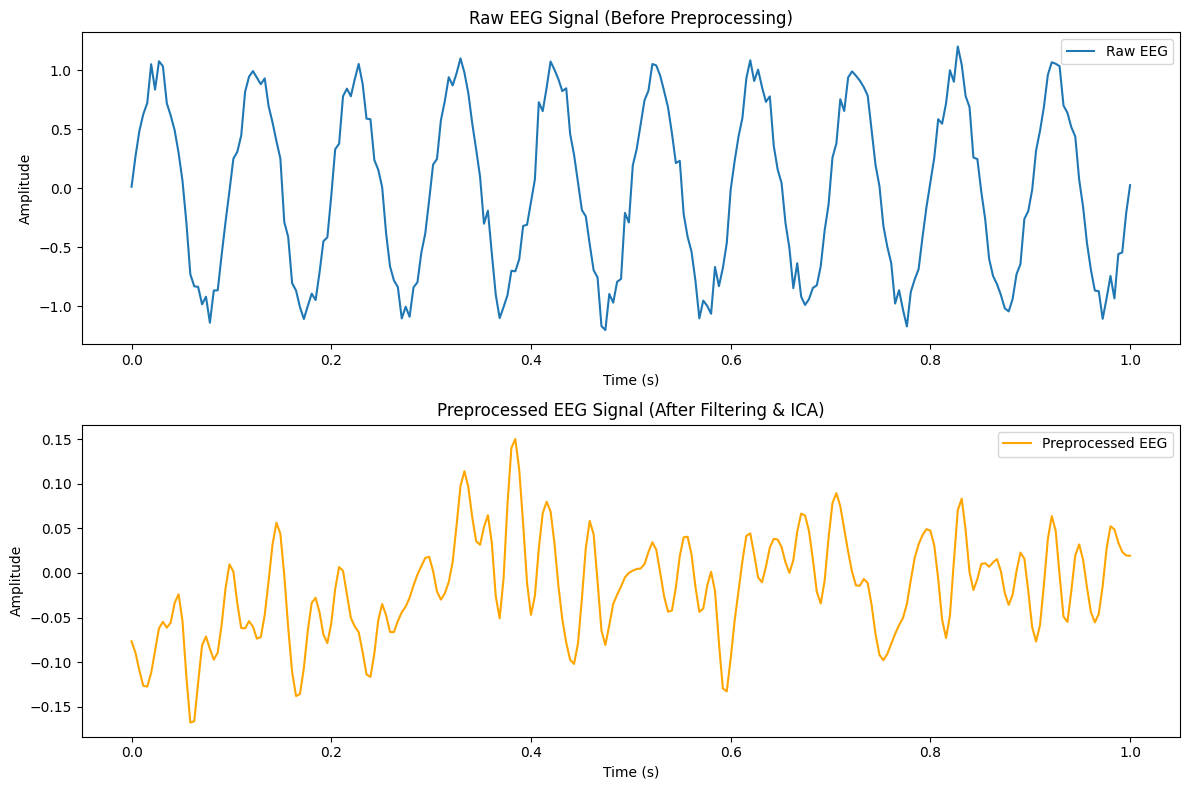

In [12]:
# %% Cell 7.5: Plot EEG Signals Before and After Preprocessing
for _ in tqdm(range(1), desc="Cell 7.5: Plotting EEG Signals"):
    pass

# Choose a sample segment, channel, and feature
segment_idx = 0   # adjust if necessary
channel_idx = 0
feature_idx = 0

raw_signal = input_data_raw[segment_idx, channel_idx, :, feature_idx]
processed_signal = input_data[segment_idx, channel_idx, :, feature_idx]

print("Raw signal shape:", raw_signal.shape)
print("Processed signal shape:", processed_signal.shape)
print("First 5 processed values:", processed_signal[:5])

time = np.linspace(0, len(raw_signal) / fs, len(raw_signal))

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, raw_signal, label="Raw EEG")
plt.title("Raw EEG Signal (Before Preprocessing)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, processed_signal, label="Preprocessed EEG", color='orange')
plt.title("Preprocessed EEG Signal (After Filtering & ICA)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# %% Cell 8: Prepare Input for the 3D CNN Model
for _ in tqdm(range(1), desc="Cell 8: Preparing Input for the Model"):
    pass

# Add a dummy "depth" dimension so that input becomes:
# (n_segments, depth=1, height=n_channels, width=window_size, channels=n_chan_features)
input_3d = input_data.reshape((input_data.shape[0], 1, n_channels, window_size, n_chan_features))
input_shape = input_3d.shape[1:]
inputs = Input(shape=input_shape)


Cell 8: Preparing Input for the Model: 100%|██████████| 1/1 [00:00<00:00, 9845.78it/s]


In [14]:
# %% Cell 9: Define Model Architecture Components
for _ in tqdm(range(1), desc="Cell 9: Defining Model Components"):
    pass

def p3d_block(input_tensor, filters, kernel_size):
    x = Conv3D(filters, kernel_size, padding='same', activation='relu')(input_tensor)
    x = Conv3D(filters, (1, kernel_size[1], kernel_size[2]), padding='same', activation='relu')(x)
    return x

def attention_layer(inputs):
    score = Dense(1, activation='tanh')(inputs)  # (batch, time, 1)
    score = Flatten()(score)                       # (batch, time)
    attention_weights = Activation('softmax')(score)  # (batch, time)
    attention_weights = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention_weights)  # (batch, time, 1)
    attended = Multiply()([inputs, attention_weights])
    return Lambda(lambda x: K.sum(x, axis=1))(attended)


Cell 9: Defining Model Components: 100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


In [15]:
# %% Cell 10: Build the Complete Model with Enhanced Regularization
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import Reshape, Lambda, Bidirectional, ConvLSTM2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

for _ in tqdm(range(1), desc="Cell 10: Building the Model"):
    pass

# Assuming 'inputs' is defined and is your input tensor.

# Apply initial P3D blocks with BatchNormalization for more stable training.
x = p3d_block(inputs, filters=32, kernel_size=(1, 3, 3))
x = BatchNormalization()(x)
x = p3d_block(x, filters=64, kernel_size=(1, 3, 3))
x = BatchNormalization()(x)

# Expected shape: (batch, depth, height, width, channels), e.g., (batch, 1, 22, 256, 64)
combined_height = x.shape[1] * x.shape[2]  # 1 * 22 = 22
x = Reshape((combined_height, x.shape[3], x.shape[4]))(x)  # (batch, 22, 256, 64)

# Simulate a time dimension for ConvLSTM2D.
time_steps = 4
target_height = (combined_height // time_steps) * time_steps  # e.g., crop 22 -> 20
x = Lambda(lambda t: t[:, :target_height, :, :])(x)  # (batch, 20, 256, 64)
new_height = target_height // time_steps  # 20 // 4 = 5
x = Reshape((time_steps, new_height, x.shape[2], x.shape[3]))(x)  # (batch, 4, 5, 256, 64)

# Apply a Bidirectional ConvLSTM2D layer with dropout and recurrent dropout.
x = Bidirectional(
    ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False,
               dropout=0.3, recurrent_dropout=0.3),
    merge_mode='concat'
)(x)  # Expected shape: (batch, new_height, width, filters), e.g., (batch, 5, 256, 64)

# Add BatchNormalization after the ConvLSTM2D layer.
x = BatchNormalization()(x)

# Flatten spatial dimensions to create a time-like dimension.
x = Reshape((-1, x.shape[-1]))(x)  # (batch, 5*256, 64) -> (batch, 1280, 64)

# Apply the attention mechanism.
x = attention_layer(x)  # Output shape: (batch, 64)

# Add Dropout for Regularization.
x = Dropout(0.5)(x)

# Final Dense layers with L2 regularization and BatchNormalization.
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


Cell 10: Building the Model: 100%|██████████| 1/1 [00:00<00:00, 8830.11it/s]


Training Progress:   5%|▌         | 1/20 [00:38<12:07, 38.29s/it, accuracy=0.904, loss=0.0347, val_loss=0.0383]


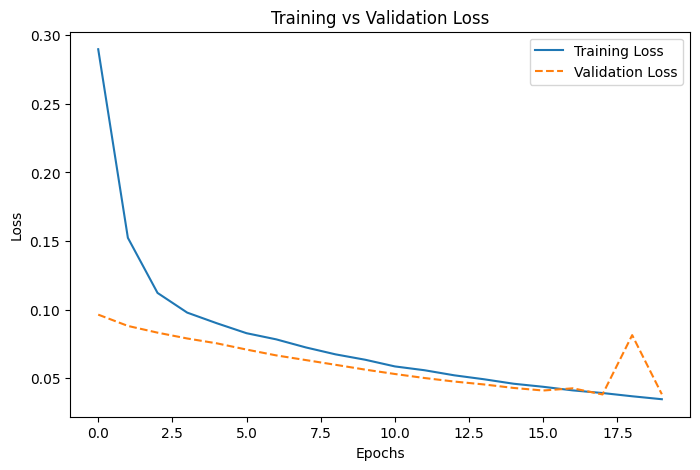

In [16]:
# %% Cell 11: Compile and Train the Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tqdm import tqdm

# Custom TQDM progress bar callback for training
class TQDMProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_progress = tqdm(total=self.params['epochs'], desc="Training Progress", position=0, leave=True)
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_progress.update(1)
        self.epoch_progress.set_postfix(loss=logs["loss"], val_loss=logs["val_loss"], accuracy=logs["accuracy"])
        if epoch == self.params['epochs'] - 1:
            self.epoch_progress.close()

# Define focal loss function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weight = alpha * tf.keras.backend.pow(1 - y_pred, gamma) * y_true + \
                 (1 - alpha) * tf.keras.backend.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return tf.keras.backend.mean(loss)
    return focal_loss_fixed

# Compile the model using Adam optimizer with gradient clipping and a lower learning rate.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
model.compile(optimizer=optimizer, 
              loss=focal_loss(gamma=2., alpha=0.25), 
              metrics=['accuracy'])

# Set up callbacks: EarlyStopping and ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model using a validation split and the custom progress bar.
history = model.fit(
    input_3d, 
    labels,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Hold out 20% of data for validation
    callbacks=[early_stop, lr_scheduler, TQDMProgressBar()],
    verbose=0  # Disable default verbose; we use TQDM for progress updates
)

# Plot Training vs. Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


# GNN

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.7 MB/s eta 0:00:0000:01
